# Combining all results

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from pathlib import Path
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_rel
import utils as ut

In [2]:
colors_seg = ['#FFC107', '#1E88E5']

## Loading and merging data

In [3]:
df_fd_BOB = pd.read_csv('outputs/BOB_fd_results.csv')
df_fd_fs_seg = pd.read_csv('outputs/BOB_fd_results_freesurfer-seg.csv')
df_seg_metrics = pd.read_csv('outputs/segmentation_metrics.csv')
df_seg_volumnes = pd.read_csv('outputs/segmentation_volumes.csv')

In [4]:
df_seg_metrics_wb = pd.read_csv('outputs/whole_brain_csf_metrics.csv')
df_seg_metrics_all = pd.concat([df_seg_metrics, df_seg_metrics_wb], ignore_index=True, sort=False)
df_seg_metrics_all.head()

participant_id session_id  label                        name     metric  \
0     sub-116056    ses-3mo    2.0  Left-Cerebral-White-Matter       Dice   
1     sub-116056    ses-3mo    2.0  Left-Cerebral-White-Matter        IoU   
2     sub-116056    ses-3mo    2.0  Left-Cerebral-White-Matter  Hausdorff   
3     sub-116056    ses-3mo    2.0  Left-Cerebral-White-Matter       HD95   
4     sub-116056    ses-3mo    2.0  Left-Cerebral-White-Matter         MI   

       value  
0   0.742034  
1   0.589868  
2  68.432448  
3   2.828427  
4   0.054265

In [5]:
common_names = pd.Series(list(set(df_fd_BOB['name'].unique()) & set(df_fd_fs_seg['name'].unique())))
df_fd_BOB_common = df_fd_BOB[df_fd_BOB['name'].isin(common_names)]
df_fd_fs_seg_common = df_fd_fs_seg[df_fd_fs_seg['name'].isin(common_names)]

df_fd_BOB_common = df_fd_BOB_common.rename(columns={'fd': 'fd_BOB'})
df_fd_fs_seg_common = df_fd_fs_seg_common.rename(columns={'fd': 'fd_SynthSeg'})

df_fd_merged = pd.merge(
    df_fd_BOB_common[['participant_id', 'session_id', 'name', 'fd_BOB','age','sex']],
    df_fd_fs_seg_common[['participant_id', 'session_id', 'name', 'fd_SynthSeg']],
    on=['participant_id', 'session_id', 'name'],
    how='inner'
)
df_fd_merged.head()

participant_id session_id                        name  fd_BOB  age   sex  \
0     sub-116056    ses-3mo                 whole_brain  2.7598  3.6  Male   
1     sub-116056    ses-3mo  Left-Cerebral-White-Matter  2.4704  3.6  Male   
2     sub-116056    ses-3mo        Left-Cerebral-Cortex  2.4475  3.6  Male   
3     sub-116056    ses-3mo      Left-Lateral-Ventricle  1.5052  3.6  Male   
4     sub-116056    ses-3mo           Left-Inf-Lat-Vent  1.3861  3.6  Male   

   fd_SynthSeg  
0       2.8088  
1       2.4882  
2       2.4989  
3       1.4089  
4       1.1902

In [6]:
df_fd_wb = pd.read_csv('outputs/fd_wb_minus_csf.csv')
# Extract age and sex
meta = (
    df_fd_merged[["participant_id","session_id","age","sex"]]
    .drop_duplicates()  # one row per unique (participant_id,session_id)
)

# Left‐join
df_fd_wb_enriched = df_fd_wb.merge(
    meta,
    on=["participant_id","session_id"],
    how="left"
)

df_fd_wb_enriched.drop(columns=['label', 'min_box_size','max_box_size'], inplace=True)
df_fd_wb_enriched.head()

participant_id session_id                   name  fd_BOB  fd_SynthSeg  age  \
0     sub-116056    ses-3mo  whole_brain_minus_CSF  2.7598       2.7760  3.6   
1     sub-116845    ses-3mo  whole_brain_minus_CSF  2.7585       2.7689  3.6   
2     sub-116845    ses-6mo  whole_brain_minus_CSF  2.7724       2.7784  6.5   
3     sub-176427    ses-5mo  whole_brain_minus_CSF  2.7594       2.7709  5.0   
4     sub-198202    ses-5mo  whole_brain_minus_CSF  2.7735       2.7850  5.9   

      sex  
0    Male  
1  Female  
2  Female  
3  Female  
4    Male

In [7]:
df_fd_all = pd.concat([df_fd_merged, df_fd_wb_enriched], ignore_index=True, sort=False)
df_fd_all.head()

participant_id session_id                        name  fd_BOB  age   sex  \
0     sub-116056    ses-3mo                 whole_brain  2.7598  3.6  Male   
1     sub-116056    ses-3mo  Left-Cerebral-White-Matter  2.4704  3.6  Male   
2     sub-116056    ses-3mo        Left-Cerebral-Cortex  2.4475  3.6  Male   
3     sub-116056    ses-3mo      Left-Lateral-Ventricle  1.5052  3.6  Male   
4     sub-116056    ses-3mo           Left-Inf-Lat-Vent  1.3861  3.6  Male   

   fd_SynthSeg  
0       2.8088  
1       2.4882  
2       2.4989  
3       1.4089  
4       1.1902

In [8]:
df_seg_volumnes_wide = df_seg_volumnes.pivot_table(
    index=['participant_id', 'session_id', 'name'],
    columns='metric',
    values='value'
).reset_index()
df_seg_volumnes_wide.head()

metric participant_id session_id                 name  volume_BOB  \
0          sub-116056    ses-3mo        3rd-Ventricle       897.0   
1          sub-116056    ses-3mo        4th-Ventricle       603.0   
2          sub-116056    ses-3mo           Brain-Stem     11435.0   
3          sub-116056    ses-3mo  Left-Accumbens-area       330.0   
4          sub-116056    ses-3mo        Left-Amygdala       708.0   

metric  volume_SynthSeg  volume_diff  volume_diff_abs  \
0                 700.0        197.0            197.0   
1                 527.0         76.0             76.0   
2               11614.0       -179.0            179.0   
3                 433.0       -103.0            103.0   
4                1091.0       -383.0            383.0   

metric  volume_norm_percent_diff  volume_ratio  
0                      24.671259      1.281429  
1                      13.451327      1.144213  
2                       1.553213      0.984588  
3                      26.998689      0.762125  
4                      42.579211      0.648946

In [9]:
df_seg_metrics_wide = df_seg_metrics_all.pivot_table(
    index=['participant_id', 'session_id', 'name'],
    columns='metric',
    values='value'
).reset_index()
df_seg_metrics_wide.head()

metric participant_id session_id                 name      Dice      HD95  \
0          sub-116056    ses-3mo        3rd-Ventricle  0.771446  1.414214   
1          sub-116056    ses-3mo        4th-Ventricle  0.736283  2.790519   
2          sub-116056    ses-3mo           Brain-Stem  0.835524  3.162278   
3          sub-116056    ses-3mo  Left-Accumbens-area  0.351245  3.000000   
4          sub-116056    ses-3mo        Left-Amygdala  0.718177  2.094419   

metric  Hausdorff       IoU        MI       NMI  
0        6.403124  0.627931  0.000772  0.690873  
1       11.445523  0.582633  0.000531  0.648855  
2       13.000000  0.717511  0.008734  0.735596  
3        3.605551  0.213037  0.000153  0.266767  
4        3.605551  0.560278  0.000792  0.637966

In [10]:
df_fd_all['fd_diff'] = df_fd_all['fd_BOB'] - df_fd_all['fd_SynthSeg']
df_fd_all['fd_diff_abs'] = df_fd_all['fd_diff'].abs()

In [11]:
df_fd_volume = pd.merge(
    df_fd_all,
    df_seg_volumnes_wide,
    on=['participant_id', 'session_id','name'],
    how='inner'
)
df_fd_volume.head()

participant_id session_id                        name  fd_BOB  age   sex  \
0     sub-116056    ses-3mo                 whole_brain  2.7598  3.6  Male   
1     sub-116056    ses-3mo  Left-Cerebral-White-Matter  2.4704  3.6  Male   
2     sub-116056    ses-3mo        Left-Cerebral-Cortex  2.4475  3.6  Male   
3     sub-116056    ses-3mo      Left-Lateral-Ventricle  1.5052  3.6  Male   
4     sub-116056    ses-3mo           Left-Inf-Lat-Vent  1.3861  3.6  Male   

   fd_SynthSeg  fd_diff  fd_diff_abs  volume_BOB  volume_SynthSeg  \
0       2.8088  -0.0490       0.0490    713007.0         928871.0   
1       2.4882  -0.0178       0.0178    147515.0         140019.0   
2       2.4989  -0.0514       0.0514    146600.0         181855.0   
3       1.4089   0.0963       0.0963      4487.0           3046.0   
4       1.1902   0.1959       0.1959       351.0            258.0   

   volume_diff  volume_diff_abs  volume_norm_percent_diff  volume_ratio  
0    -215864.0         215864.0                 26.294767      0.767606  
1       7496.0           7496.0                  5.213992      1.053536  
2     -35255.0          35255.0                 21.467172      0.806137  
3       1441.0           1441.0                 38.258330      1.473079  
4         93.0             93.0                 30.541872      1.360465

In [12]:
df_fd_volume_metrics = pd.merge(
    df_fd_volume,
    df_seg_metrics_wide,
    on=['participant_id', 'session_id','name'],
    how='inner'
)
df_fd_volume_metrics.head()

participant_id session_id                        name  fd_BOB  age   sex  \
0     sub-116056    ses-3mo                 whole_brain  2.7598  3.6  Male   
1     sub-116056    ses-3mo  Left-Cerebral-White-Matter  2.4704  3.6  Male   
2     sub-116056    ses-3mo        Left-Cerebral-Cortex  2.4475  3.6  Male   
3     sub-116056    ses-3mo      Left-Lateral-Ventricle  1.5052  3.6  Male   
4     sub-116056    ses-3mo           Left-Inf-Lat-Vent  1.3861  3.6  Male   

   fd_SynthSeg  fd_diff  fd_diff_abs  volume_BOB  ...  volume_diff  \
0       2.8088  -0.0490       0.0490    713007.0  ...    -215864.0   
1       2.4882  -0.0178       0.0178    147515.0  ...       7496.0   
2       2.4989  -0.0514       0.0514    146600.0  ...     -35255.0   
3       1.4089   0.0963       0.0963      4487.0  ...       1441.0   
4       1.1902   0.1959       0.1959       351.0  ...         93.0   

   volume_diff_abs  volume_norm_percent_diff  volume_ratio      Dice  \
0         215864.0                 26.294767      0.767606  0.868057   
1           7496.0                  5.213992      1.053536  0.742034   
2          35255.0                 21.467172      0.806137  0.703688   
3           1441.0                 38.258330      1.473079  0.677818   
4             93.0                 30.541872      1.360465  0.397373   

        HD95  Hausdorff       IoU        MI       NMI  
0  20.099751  58.864251  0.766874  0.251933  0.713601  
1   2.828427  68.432448  0.589868  0.054265  0.555543  
2   2.000000   7.071068  0.542839  0.055091  0.508236  
3   3.506543  19.235384  0.512651  0.002552  0.572870  
4   2.828427  33.301652  0.247951  0.000145  0.310883  

[5 rows x 21 columns]

## Volume

In [13]:
base_list = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']
base_list.sort()

### BOB vs. SynthSeg

In [33]:
stats_list = []

for label in base_list:
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == label]
    if sub.empty:
        continue  # Skip if no data
    
    bob = sub['volume_BOB']
    synthseg = sub['volume_SynthSeg']
    diff = bob - synthseg
    
    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(bob, synthseg)

    d_val = ut.cohen_d_paired(bob, synthseg)
    
    stats_list.append({
        'name': label,
        'Volume (BOB)': f"{bob.mean():.0f} ± {bob.std(ddof=1):.0f}",
        'Volume (SynthSeg)': f"{synthseg.mean():.0f} ± {synthseg.std(ddof=1):.0f}",
        'Volume (diff)': f"{mean_diff:.0f} ± {sd_diff:.0f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats_vol = pd.DataFrame(stats_list)
df_stats_vol

name     Volume (BOB) Volume (SynthSeg)  \
0                   3rd-Ventricle        641 ± 142         544 ± 178   
1                   4th-Ventricle        760 ± 168         567 ± 208   
2                      Brain-Stem      9813 ± 1381      11060 ± 2448   
3             Left-Accumbens-area        324 ± 104         501 ± 110   
4                   Left-Amygdala        779 ± 196        1045 ± 187   
5                    Left-Caudate       2651 ± 549        2264 ± 602   
6          Left-Cerebellum-Cortex     28288 ± 7262      35067 ± 8683   
7    Left-Cerebellum-White-Matter      5740 ± 2270       4525 ± 1412   
8            Left-Cerebral-Cortex   158001 ± 37843    183813 ± 28137   
9      Left-Cerebral-White-Matter   127721 ± 20411    120150 ± 19168   
10               Left-Hippocampus       1734 ± 394        2278 ± 505   
11              Left-Inf-Lat-Vent        379 ± 171          259 ± 88   
12         Left-Lateral-Ventricle      4859 ± 1776       3593 ± 1823   
13                  Left-Pallidum       1204 ± 408        1036 ± 279   
14                   Left-Putamen       3124 ± 606        3830 ± 623   
15                  Left-Thalamus       6696 ± 683        5577 ± 466   
16           Right-Accumbens-area        313 ± 104         585 ± 116   
17                 Right-Amygdala        795 ± 166        1059 ± 240   
18                  Right-Caudate       2718 ± 672        2428 ± 574   
19        Right-Cerebellum-Cortex     28233 ± 7707      31969 ± 9028   
20  Right-Cerebellum-White-Matter      6186 ± 2459       4333 ± 1421   
21          Right-Cerebral-Cortex   156209 ± 38328    183816 ± 27958   
22    Right-Cerebral-White-Matter   130404 ± 22572    119840 ± 18887   
23              Right-Hippocampus       1812 ± 431        2469 ± 527   
24             Right-Inf-Lat-Vent        325 ± 150         246 ± 101   
25        Right-Lateral-Ventricle      4076 ± 1259       3357 ± 1352   
26                 Right-Pallidum       1078 ± 301        1111 ± 268   
27                  Right-Putamen       3366 ± 542        3656 ± 646   
28                 Right-Thalamus       6304 ± 564        5817 ± 506   
29                Right-VentralDC       2014 ± 819        2526 ± 400   
30                    whole_brain  701130 ± 125256   868826 ± 135069   
31          whole_brain_minus_CSF  700704 ± 124984   741635 ± 120116   

      Volume (diff)   n  p-val      d  
0           97 ± 65  70  0.000   1.49  
1         193 ± 103  70  0.000   1.88  
2      -1247 ± 1451  71  0.000  -0.86  
3        -178 ± 130  71  0.000  -1.36  
4        -266 ± 140  71  0.000  -1.91  
5         387 ± 253  71  0.000   1.53  
6      -6779 ± 2365  71  0.000  -2.87  
7       1215 ± 1200  71  0.000   1.01  
8    -25812 ± 16199  71  0.000  -1.59  
9      7571 ± 12622  71  0.000   0.60  
10       -544 ± 291  71  0.000  -1.87  
11        120 ± 132  71  0.000   0.91  
12       1266 ± 841  70  0.000   1.51  
13        168 ± 203  71  0.000   0.83  
14       -706 ± 279  71  0.000  -2.53  
15       1118 ± 532  70  0.000   2.10  
16       -272 ± 125  71  0.000  -2.18  
17       -263 ± 139  71  0.000  -1.89  
18        289 ± 297  70  0.000   0.98  
19     -3736 ± 2786  71  0.000  -1.34  
20      1853 ± 1366  71  0.000   1.36  
21   -27608 ± 18002  71  0.000  -1.53  
22    10563 ± 14196  71  0.000   0.74  
23       -657 ± 327  71  0.000  -2.01  
24         80 ± 108  71  0.000   0.74  
25        719 ± 893  70  0.000   0.80  
26        -33 ± 191  71  0.146  -0.17  
27       -291 ± 252  71  0.000  -1.16  
28        486 ± 398  70  0.000   1.22  
29       -513 ± 668  71  0.000  -0.77  
30  -167696 ± 28984  71  0.000  -5.79  
31   -40931 ± 18372  71  0.000  -2.23

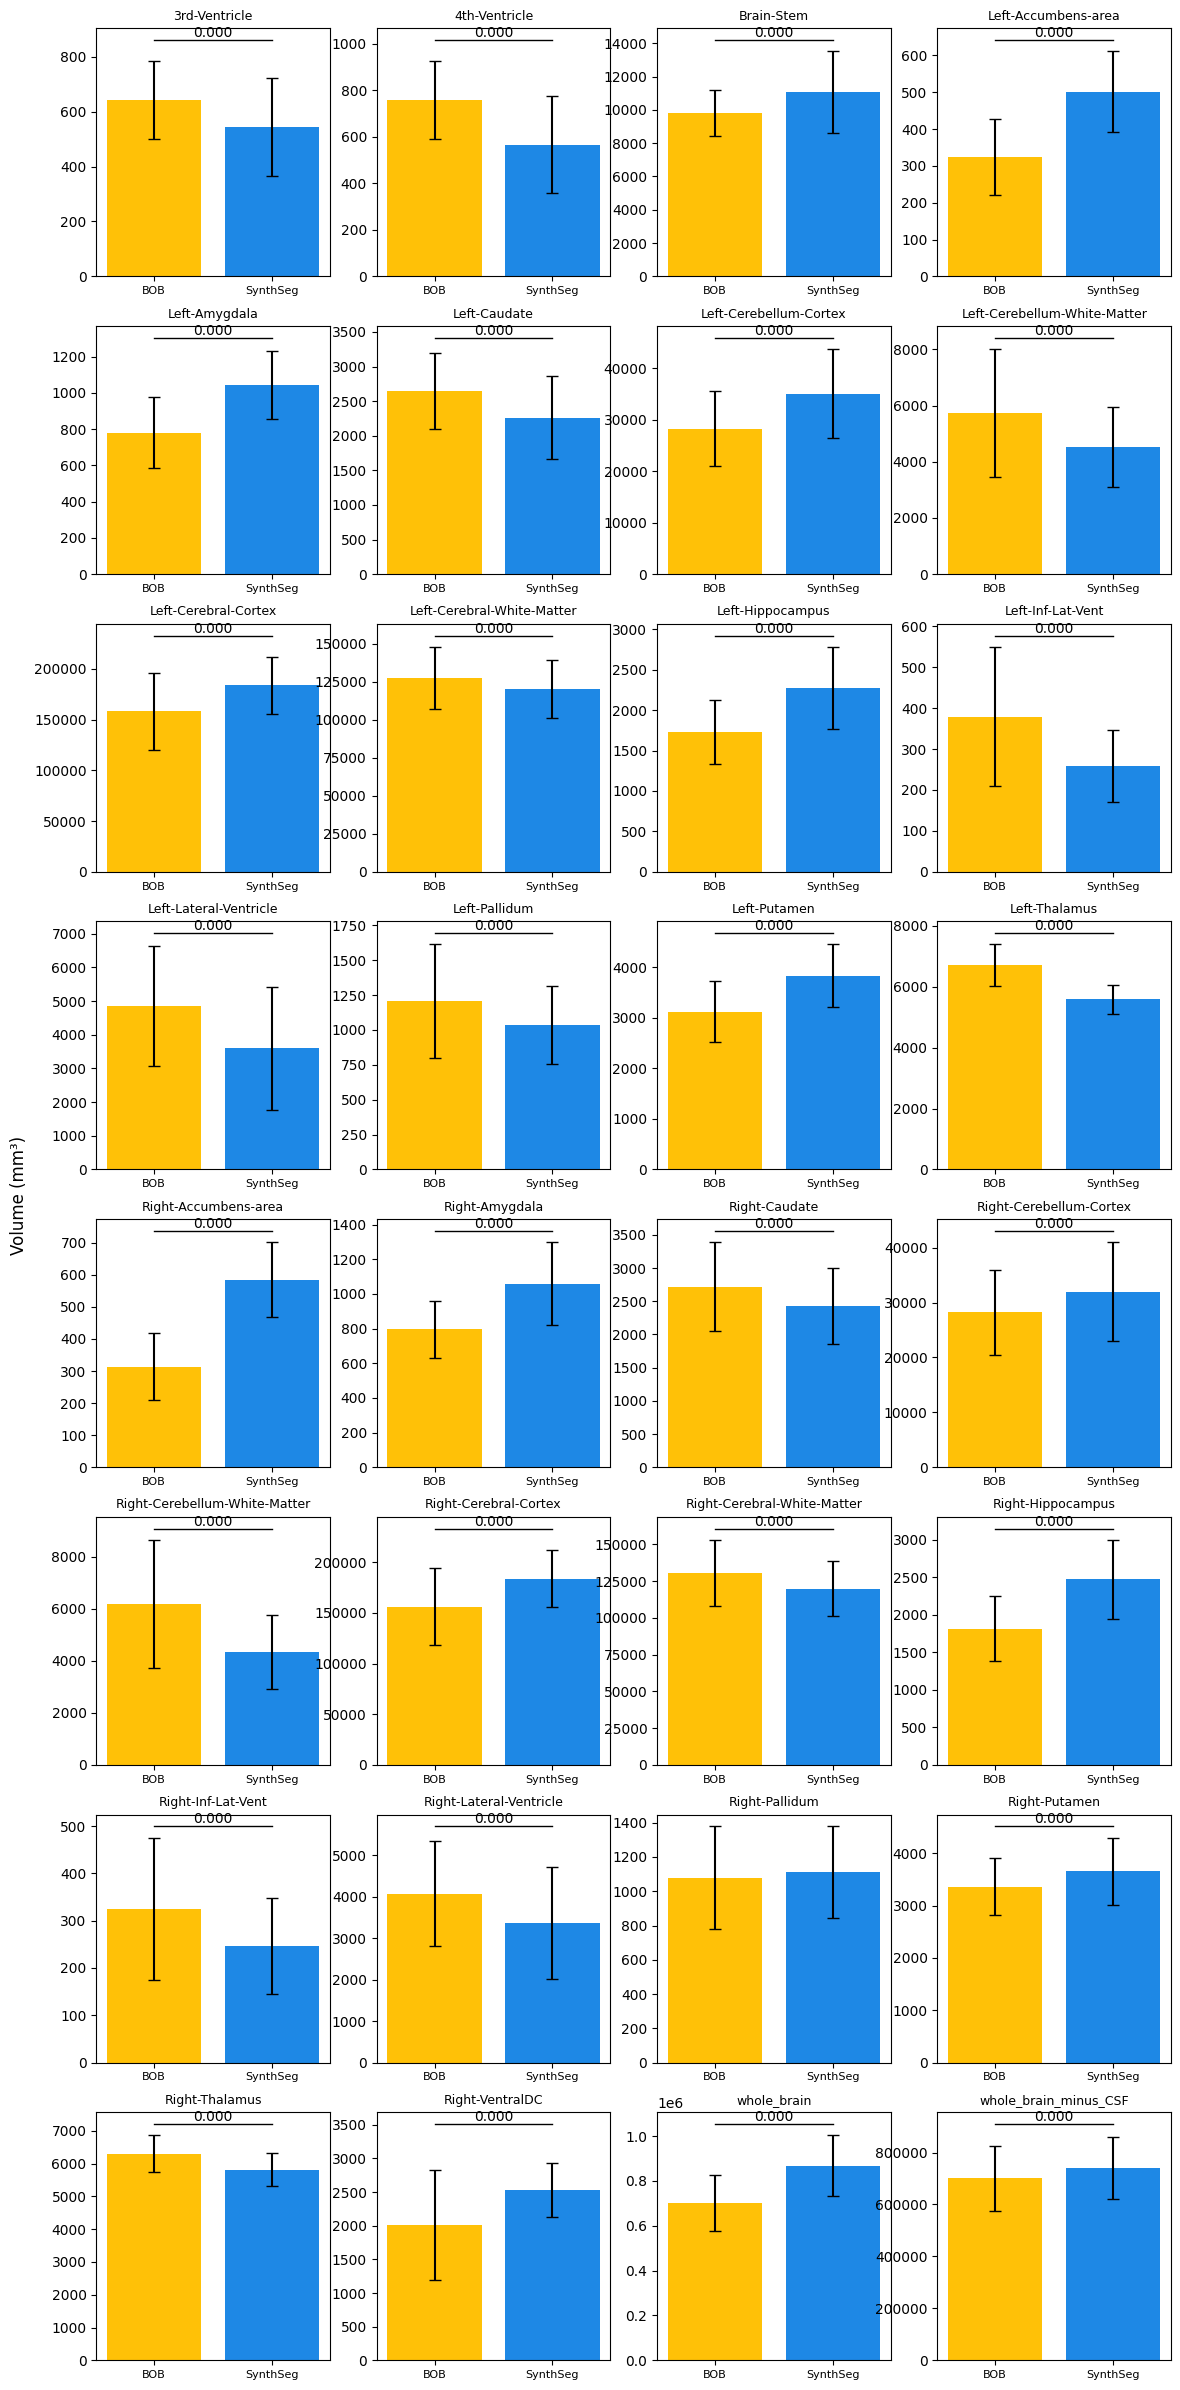

In [34]:
agg = df_fd_volume_metrics.groupby('name')[['volume_BOB', 'volume_SynthSeg']].agg(['mean', 'std'])

n_pairs = len(base_list)
ncols = 4
nrows = int(np.ceil(n_pairs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=False)
axes = axes.flatten()

for ax, label in zip(axes, base_list):
    if label not in agg.index:
        ax.axis('off')
        continue
    means = agg.loc[label][('volume_BOB', 'mean')], agg.loc[label][('volume_SynthSeg', 'mean')]
    stds  = agg.loc[label][('volume_BOB', 'std')],  agg.loc[label][('volume_SynthSeg', 'std')]

    x = np.arange(2)
    ax.bar(x, means, yerr=stds, capsize=4, color=colors_seg)
    ax.set_xticks(x)
    ax.set_xticklabels(['BOB', 'SynthSeg'], fontsize=8)
    ax.set_title(label, fontsize=9)

    # Annotate mean values
    # for xi, m, sd in zip(x, means, stds):
    #     ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)

        
    # Significance p-value
    p = float(df_stats_vol[df_stats_vol['name'] == label]['p-val'].iloc[0])
    if p < 0.05:
        y0 = (max(means) + max(stds))*1.05
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}", ha='center', va='bottom', fontsize=10)


# Turn off empty subplots
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Volume (mm³)", fontsize=12)
# plt.setp(axes, ylim=(0, 3.4))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

Showing the sign. differences after Bonferroni correction 

In [32]:
# number of paired tests
n_tests = len(df_stats_vol)
alpha_corr = 0.05 / n_tests

df_stats_vol['p_nominal'] = df_stats_vol['p-val'].astype(float)
df_stats_vol['sign_corr'] = df_stats_vol['p_nominal'] < alpha_corr

print(f"Bonferroni α = {alpha_corr:.4f}")
df_stats_vol.loc[df_stats_vol['sign_corr'], ['name', 'Volume (BOB)', 'Volume (SynthSeg)', 'Volume (diff)', 'p-val', 'd']]

Bonferroni α = 0.0016


name           Volume (BOB)  \
0                   3rd-Ventricle        640.96 ± 141.87   
1                   4th-Ventricle        759.96 ± 168.16   
2                      Brain-Stem      9813.38 ± 1380.56   
3             Left-Accumbens-area        323.72 ± 103.58   
4                   Left-Amygdala        779.03 ± 195.87   
5                    Left-Caudate       2650.55 ± 548.57   
6          Left-Cerebellum-Cortex     28287.99 ± 7261.82   
7    Left-Cerebellum-White-Matter      5740.14 ± 2270.34   
8            Left-Cerebral-Cortex   158000.76 ± 37843.34   
9      Left-Cerebral-White-Matter   127721.01 ± 20410.51   
10               Left-Hippocampus       1733.61 ± 394.25   
11              Left-Inf-Lat-Vent        379.37 ± 170.66   
12         Left-Lateral-Ventricle      4859.34 ± 1776.00   
13                  Left-Pallidum       1203.75 ± 408.32   
14                   Left-Putamen       3124.37 ± 606.30   
15                  Left-Thalamus       6695.71 ± 682.62   
16           Right-Accumbens-area        313.00 ± 104.48   
17                 Right-Amygdala        795.44 ± 166.41   
18                  Right-Caudate       2717.76 ± 672.32   
19        Right-Cerebellum-Cortex     28232.70 ± 7707.44   
20  Right-Cerebellum-White-Matter      6186.34 ± 2458.96   
21          Right-Cerebral-Cortex   156208.59 ± 38328.47   
22    Right-Cerebral-White-Matter   130403.96 ± 22571.89   
23              Right-Hippocampus       1812.45 ± 430.61   
24             Right-Inf-Lat-Vent        325.39 ± 150.17   
25        Right-Lateral-Ventricle      4076.00 ± 1259.09   
27                  Right-Putamen       3365.58 ± 542.08   
28                 Right-Thalamus       6303.54 ± 564.32   
29                Right-VentralDC       2013.54 ± 818.52   
30                    whole_brain  701130.38 ± 125256.46   
31          whole_brain_minus_CSF  700703.55 ± 124984.09   

        Volume (SynthSeg)          Volume (diff)  p-val      d  
0         544.31 ± 178.15          96.64 ± 64.91  0.000   1.49  
1         566.83 ± 208.10        193.13 ± 102.57  0.000   1.88  
2      11059.94 ± 2448.11     -1246.56 ± 1450.84  0.000  -0.86  
3         501.34 ± 109.76       -177.62 ± 130.49  0.000  -1.36  
4        1045.37 ± 187.10       -266.34 ± 139.68  0.000  -1.91  
5        2263.68 ± 602.02        386.87 ± 253.17  0.000   1.53  
6      35066.68 ± 8683.28     -6778.69 ± 2364.85  0.000  -2.87  
7       4525.20 ± 1412.06      1214.94 ± 1200.43  0.000   1.01  
8    183812.56 ± 28137.15   -25811.80 ± 16198.93  0.000  -1.59  
9    120149.59 ± 19167.59     7571.42 ± 12622.35  0.000   0.60  
10       2277.62 ± 505.38       -544.01 ± 291.42  0.000  -1.87  
11         258.99 ± 88.46        120.38 ± 131.65  0.000   0.91  
12      3593.39 ± 1823.15       1265.96 ± 840.73  0.000   1.51  
13       1036.00 ± 279.36        167.75 ± 203.05  0.000   0.83  
14       3830.37 ± 622.53       -706.00 ± 279.12  0.000  -2.53  
15       5577.39 ± 466.38       1118.33 ± 531.85  0.000   2.10  
16        585.49 ± 116.48       -272.49 ± 124.91  0.000  -2.18  
17       1058.55 ± 240.22       -263.11 ± 139.45  0.000  -1.89  
18       2428.34 ± 573.78        289.41 ± 296.81  0.000   0.98  
19     31968.87 ± 9027.64     -3736.17 ± 2785.75  0.000  -1.34  
20      4332.99 ± 1421.15      1853.35 ± 1366.27  0.000   1.36  
21   183816.14 ± 27957.80   -27607.55 ± 18001.92  0.000  -1.53  
22   119840.49 ± 18886.81    10563.46 ± 14195.82  0.000   0.74  
23       2469.01 ± 526.81       -656.56 ± 326.54  0.000  -2.01  
24        245.83 ± 101.03         79.56 ± 107.74  0.000   0.74  
25      3357.11 ± 1351.89        718.89 ± 893.26  0.000   0.80  
27       3656.39 ± 645.91       -290.82 ± 251.77  0.000  -1.16  
28       5817.27 ± 505.61        486.27 ± 397.57  0.000   1.22  
29       2526.39 ± 400.09       -512.86 ± 668.03  0.000  -0.77  
30  868825.90 ± 135068.51  -167695.52 ± 28984.05  0.000  -5.79  
31  741634.70 ± 120116.25   -40931.15 ± 18372.18  0.000  -2.23

### BOB/SynthSeg over age

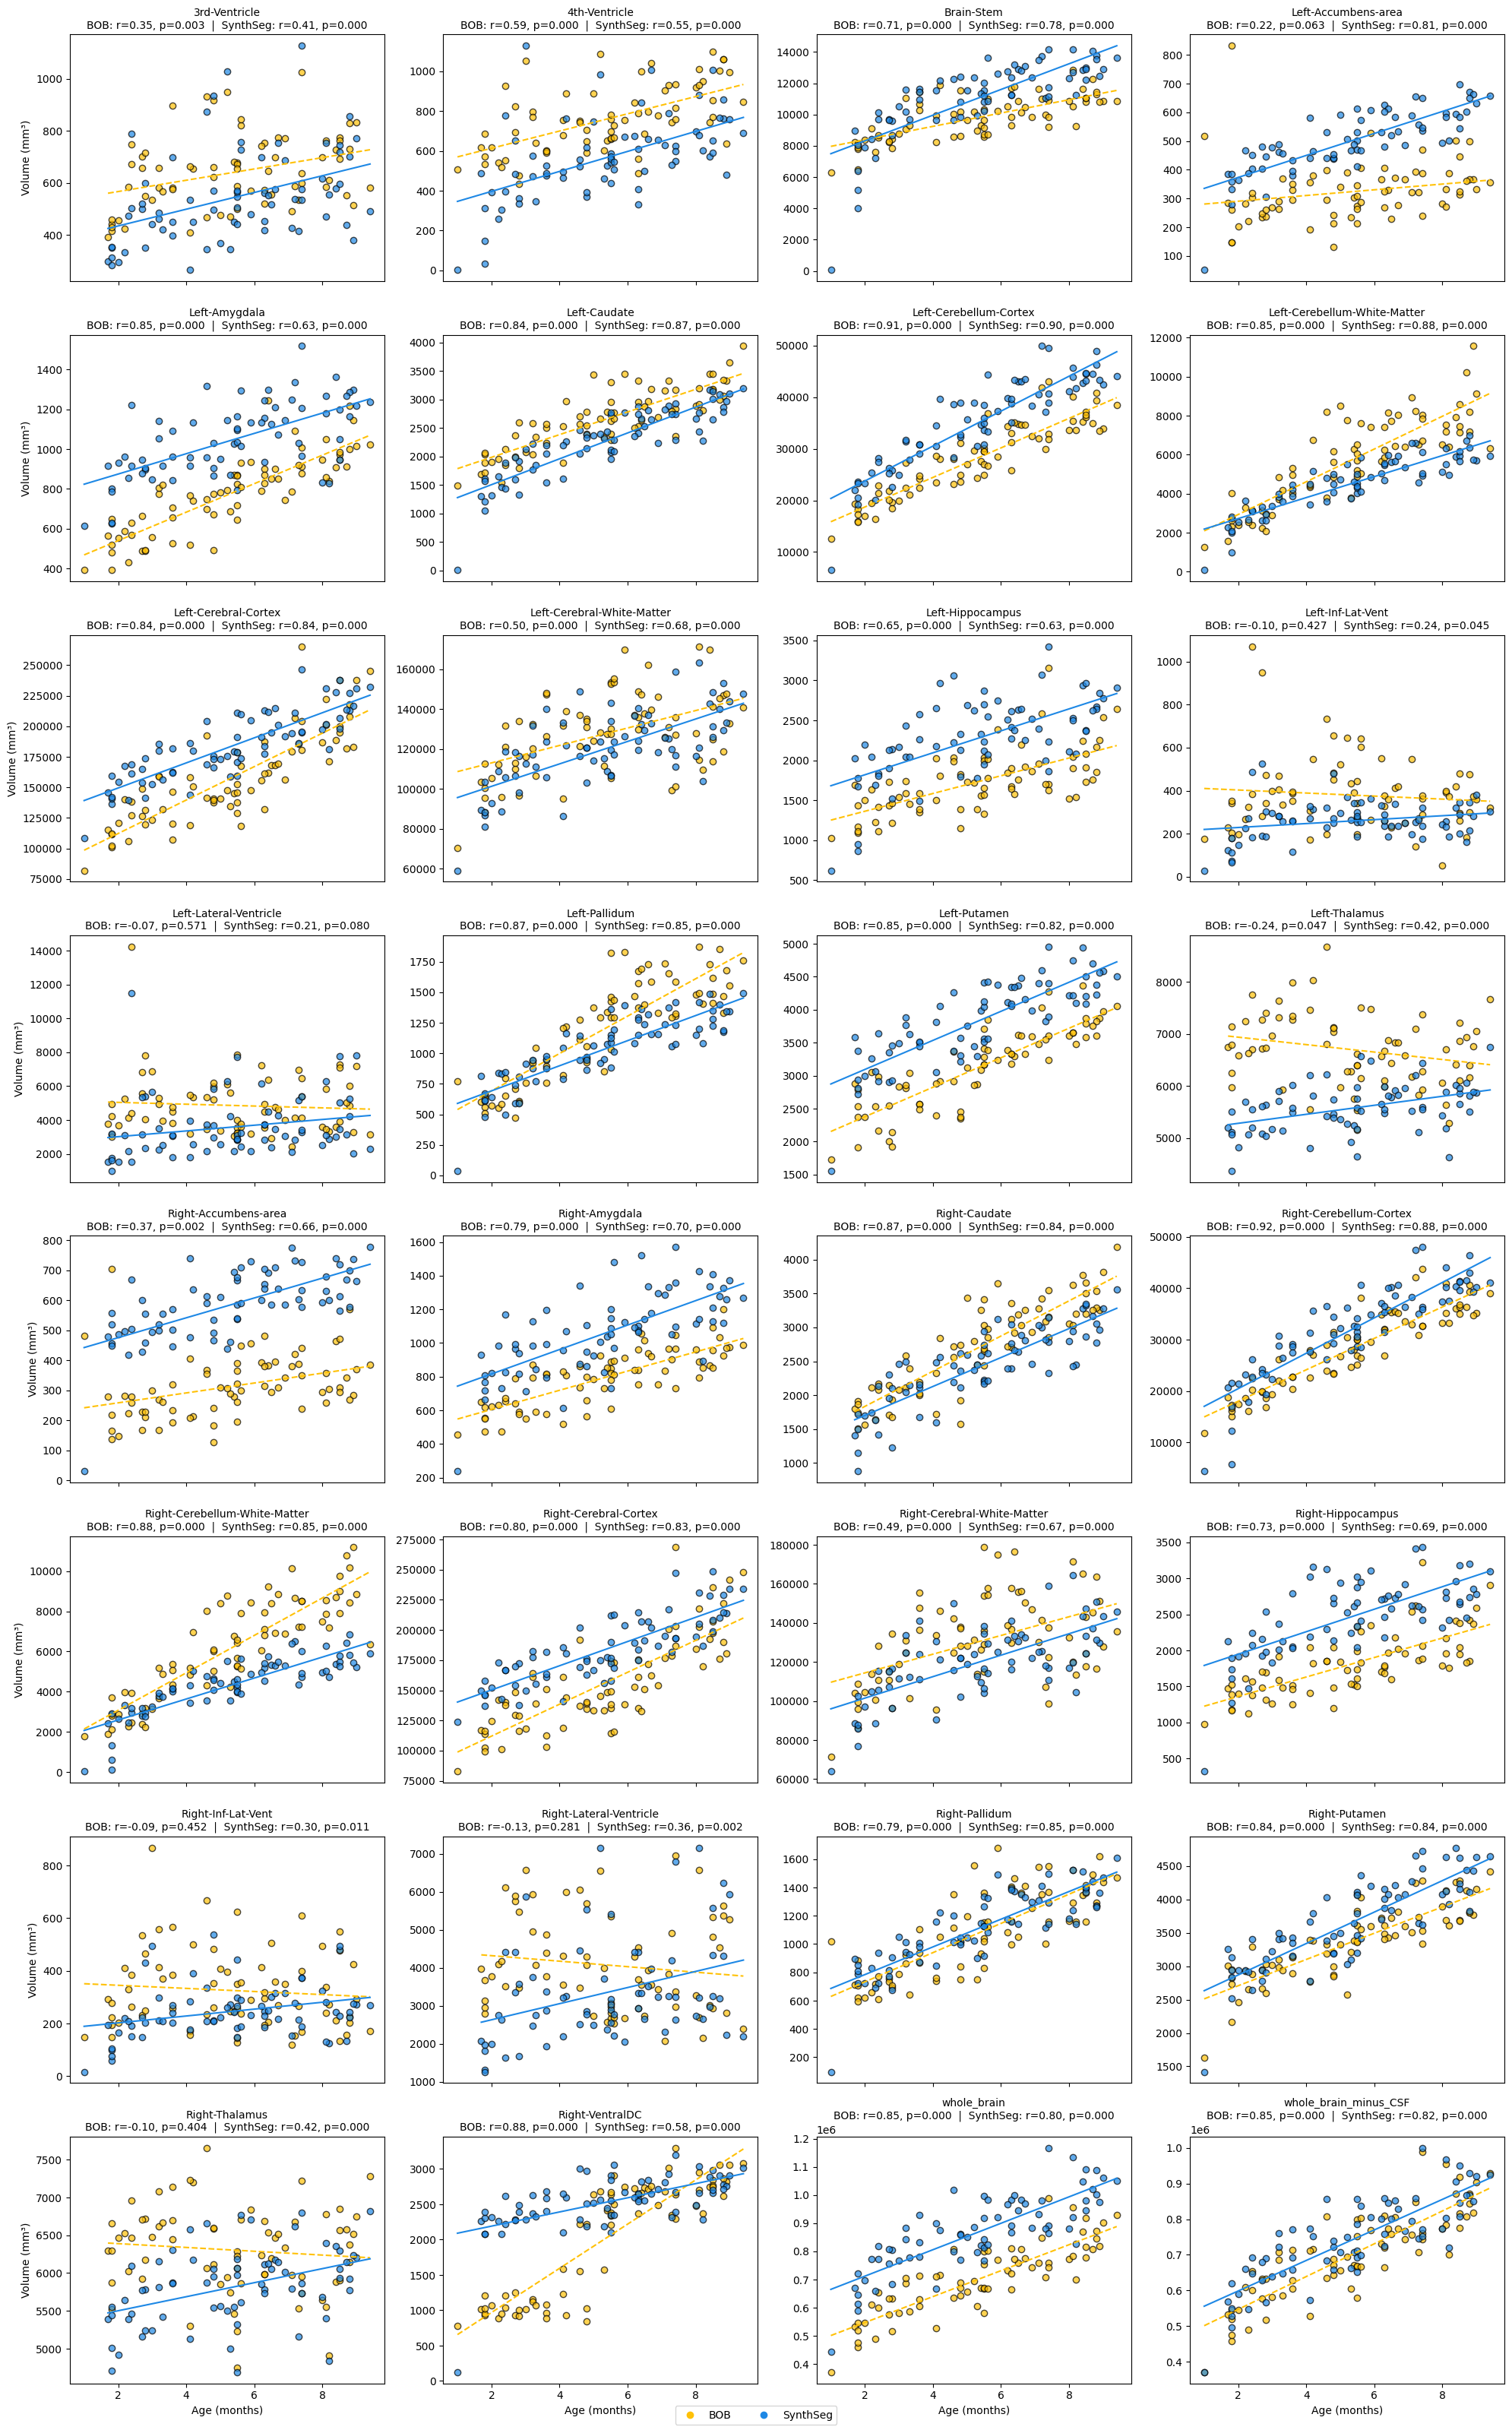

In [ ]:
n = len(base_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 5, nrows * 4),
    sharex=True
)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    
    # Subset for this structure
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == base]
    ages = sub['age'].values
    
    # Grab volume columns instead of FD
    vols_BOB      = sub['volume_BOB'].values
    vols_SynthSeg = sub['volume_SynthSeg'].values
    
    # Scatter plot for each method
    ax.scatter(
        ages, vols_BOB,
        label='BOB',
        color=colors_seg[0],
        edgecolor='k',
        alpha=0.7
    )
    ax.scatter(
        ages, vols_SynthSeg,
        label='SynthSeg',
        color=colors_seg[1],
        edgecolor='k',
        alpha=0.7
    )
    
    # Fit regression line for BOB
    if len(ages) > 1:
        slope_bob, intercept_bob = np.polyfit(ages, vols_BOB, 1)
        x_line = np.linspace(ages.min(), ages.max(), 100)
        y_line_bob = slope_bob * x_line + intercept_bob
        ax.plot(
            x_line, y_line_bob,
            color=colors_seg[0], linestyle='--'
        )

    # Fit regression line for SynthSeg
    if len(ages) > 1:
        slope_ss, intercept_ss = np.polyfit(ages, vols_SynthSeg, 1)
        y_line_ss = slope_ss * x_line + intercept_ss
        ax.plot(
            x_line, y_line_ss,
            color=colors_seg[1], linestyle='-'
        )
    
    # Pearson correlations
    if len(ages) > 1:
        r_bob, p_bob = pearsonr(ages, vols_BOB)
        r_ss,  p_ss  = pearsonr(ages, vols_SynthSeg)
    else:
        r_bob = p_bob = r_ss = p_ss = np.nan

    ax.set_title(
        f"{base}\n"
        f"BOB: r={r_bob:.2f}, p={p_bob:.3f}  |  "
        f"SynthSeg: r={r_ss:.2f}, p={p_ss:.3f}",
        fontsize=10
    )
    
    # Only label x‐axis on the bottom row
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    # Only label y‐axis on the left column
    if idx % ncols == 0:
        ax.set_ylabel("Volume (mm³)")

# Turn off any unused axes
for j in range(n, len(axes)):
    axes[j].axis('off')

# Single legend at bottom
handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               color=colors_seg[0], label='BOB'),
    plt.Line2D([], [], marker='o', linestyle='None',
               color=colors_seg[1], label='SynthSeg')
]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()


### Correlation with quality metrics

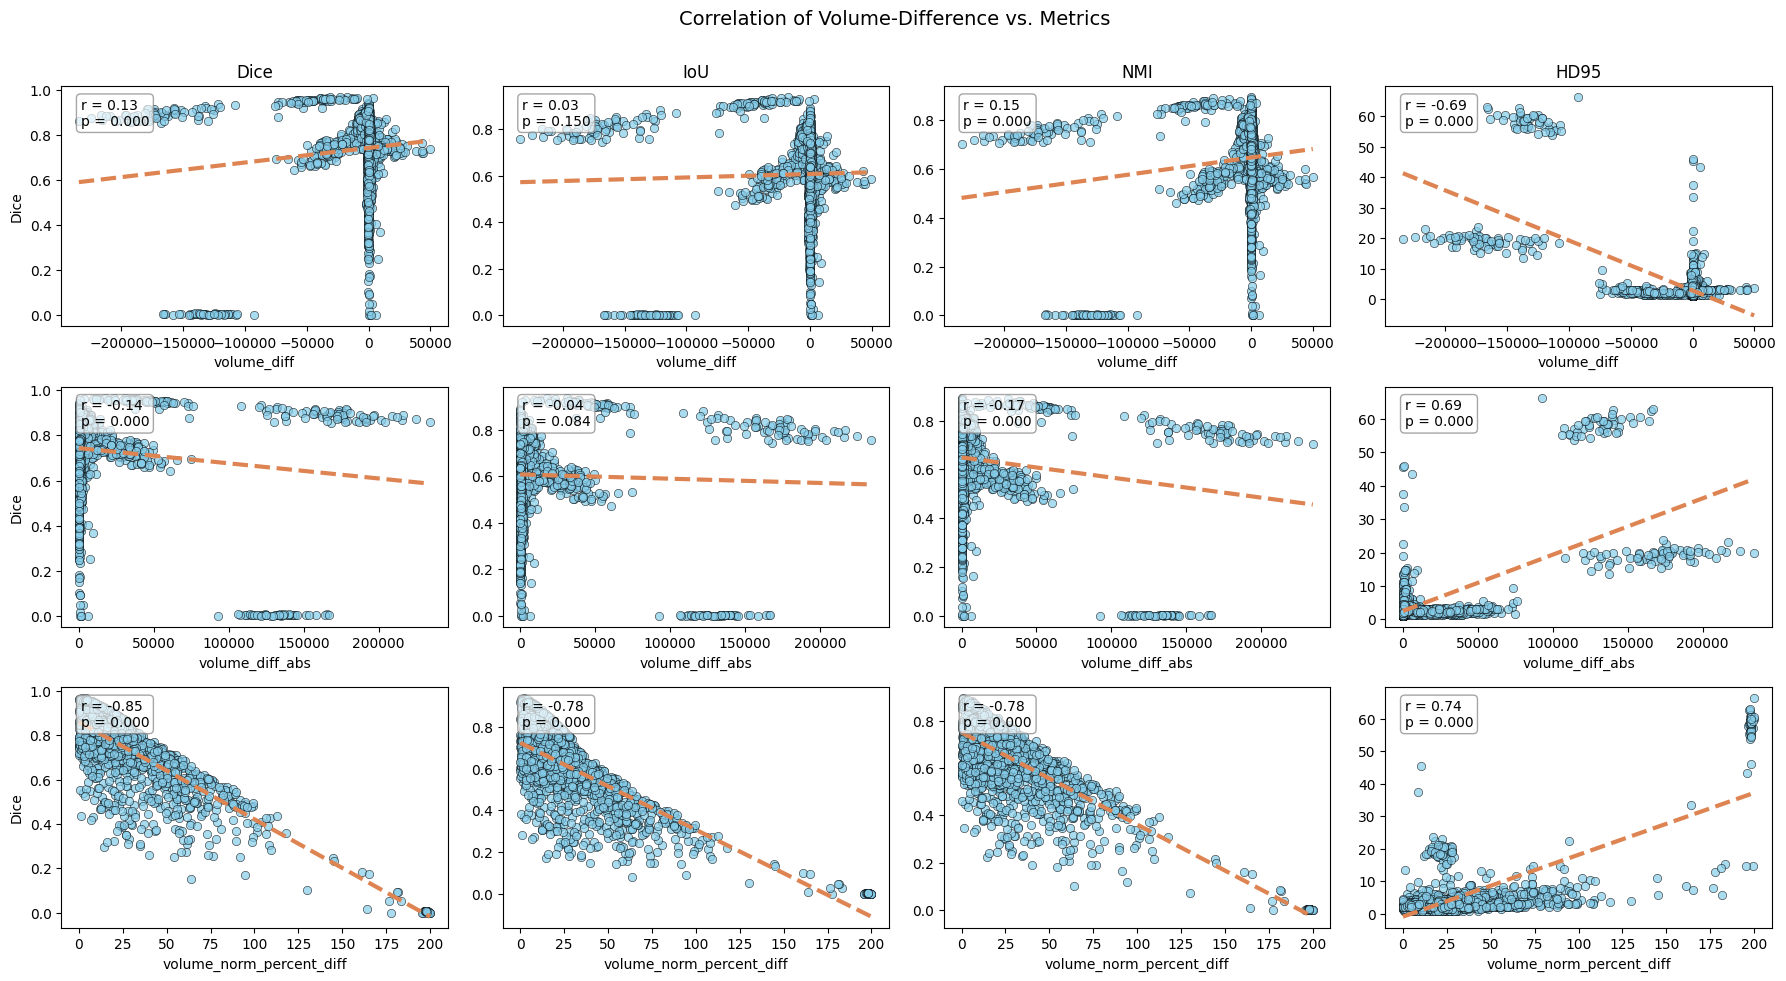

In [100]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_cols  = ["volume_diff", "volume_diff_abs", "volume_norm_percent_diff"]

nrows = len(x_cols)   # 3
ncols = len(metrics)  # 4

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 4.5, nrows * 3.5),
    sharex=False
)

# Flatten axes for easy indexing if needed, but we'll also use a 2D index:
axes = np.array(axes)

for i, x_col in enumerate(x_cols):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # Filter out NaNs
        sub = df_fd_volume_metrics.dropna(subset=[x_col, metric])
        x = sub[x_col].values
        y = sub[metric].values
        
        # Scatter plot
        sns.scatterplot(x=x, y=y, ax=ax, color='skyblue', edgecolor='k', alpha=0.7)

        
        # Fit regression line if ≥ 2 points
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color="#dd8452", linestyle="--",lw=3)
        
        # Pearson correlation
        if len(x) > 1:
            r, p = pearsonr(x, y)
        else:
            r, p = np.nan, np.nan
        
        # Annotate r and p in top-left
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor="gray",
                alpha=0.7
            )
        )
        
        # Only set titles on the top row
        if i == 0:
            ax.set_title(metric, fontsize=12)
        
        # Only label y‐axis on the first column
        if j == 0:
            ax.set_ylabel(metric, fontsize=10)
        else:
            ax.set_ylabel("")
        

        ax.set_xlabel(x_col, fontsize=10)

# Tight layout and super‐title
fig.suptitle("Correlation of Volume‐Difference vs. Metrics", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.975])
plt.show()


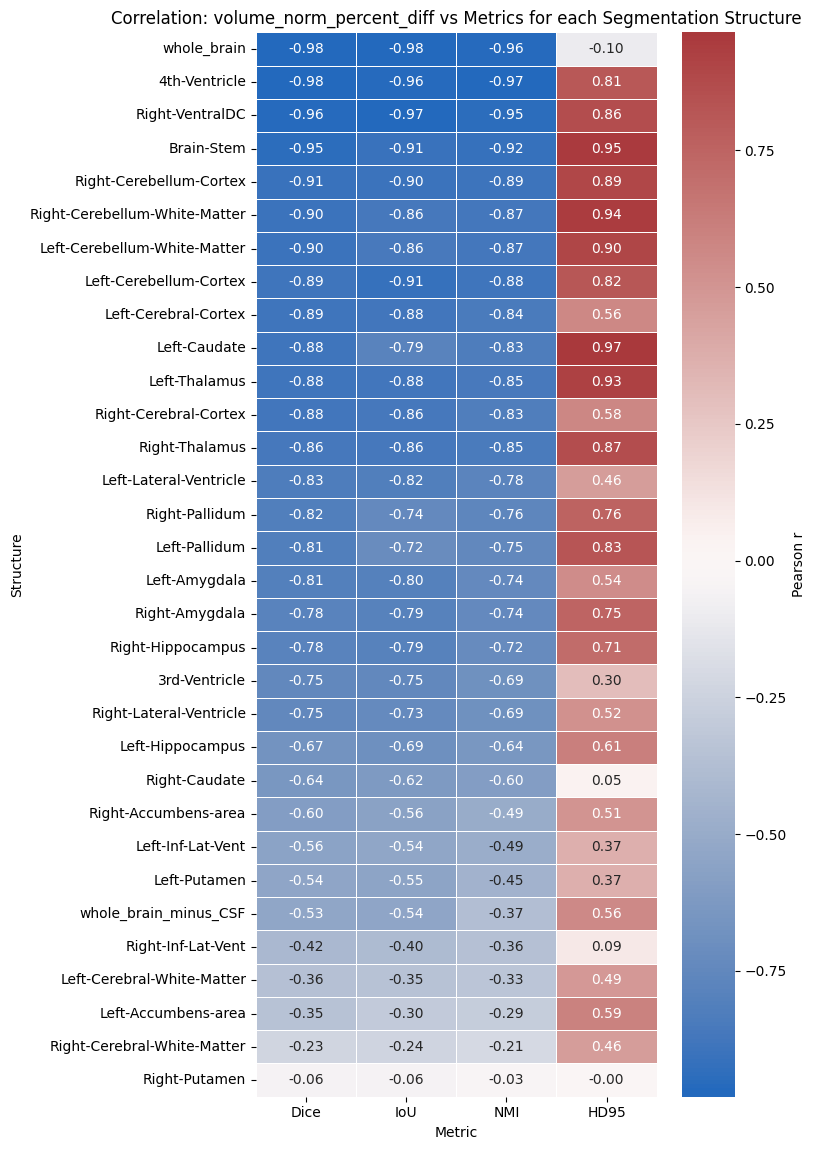

In [ ]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_col = "volume_norm_percent_diff"

structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

corr_df = pd.DataFrame(index=structures, columns=metrics, dtype=float)

# fill in corr_df for each structure & each metric, compute Pearson r
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    for metric in metrics:
        # Drop NaNs
        valid = sub[[x_col, metric]].dropna()
        if len(valid) > 1:
            r, _ = pearsonr(valid[x_col], valid[metric])
        else:
            r = np.nan
        corr_df.at[struct, metric] = r

corr_df = corr_df.sort_values(by="Dice", ascending=True)

# plot a heatmap of the correlation coefficients
plt.figure(figsize=(8, len(structures) * 0.3 + 2))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="vlag",     # diverging palette centered at 0
    center=0,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5
)
plt.title(f"Correlation: {x_col} vs Metrics for each Segmentation Structure")
plt.xlabel("Metric")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()


## Fractal dimension

In [ ]:
base_list = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']
base_list.sort()

### BOB vs. SynthSeg

In [26]:
stats_list = []

for label in base_list:
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == label]
    if sub.empty:
        continue  # Skip if no data
    
    bob = sub['fd_BOB']
    synthseg = sub['fd_SynthSeg']
    diff = bob - synthseg
    
    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(bob, synthseg)

    d_val = ut.cohen_d_paired(bob, synthseg)
    
    stats_list.append({
        'name': label,
        'FD (BOB)': f"{bob.mean():.2f} ± {bob.std(ddof=1):.2f}",
        'FD (SynthSeg)': f"{synthseg.mean():.2f} ± {synthseg.std(ddof=1):.2f}",
        'FD (diff)': f"{mean_diff:.2f} ± {sd_diff:.2f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats = pd.DataFrame(stats_list)
df_stats

name     FD (BOB) FD (SynthSeg)     FD (diff)  \
0                   3rd-Ventricle  1.74 ± 0.11   1.63 ± 0.23   0.11 ± 0.17   
1                   4th-Ventricle  1.67 ± 0.15   1.50 ± 0.40   0.17 ± 0.42   
2                      Brain-Stem  2.29 ± 0.02   2.27 ± 0.22   0.02 ± 0.22   
3             Left-Accumbens-area  1.62 ± 0.08   1.64 ± 0.20  -0.02 ± 0.23   
4                   Left-Amygdala  1.84 ± 0.15   1.89 ± 0.19  -0.04 ± 0.20   
5                    Left-Caudate  2.02 ± 0.04   1.87 ± 0.33   0.15 ± 0.31   
6          Left-Cerebellum-Cortex  2.44 ± 0.03   2.48 ± 0.04  -0.04 ± 0.03   
7    Left-Cerebellum-White-Matter  2.07 ± 0.06   2.04 ± 0.14   0.03 ± 0.12   
8            Left-Cerebral-Cortex  2.47 ± 0.05   2.51 ± 0.01  -0.05 ± 0.04   
9      Left-Cerebral-White-Matter  2.43 ± 0.04   2.45 ± 0.01  -0.02 ± 0.04   
10               Left-Hippocampus  1.91 ± 0.10   1.96 ± 0.08  -0.05 ± 0.10   
11              Left-Inf-Lat-Vent  1.35 ± 0.19   1.22 ± 0.14   0.14 ± 0.23   
12         Left-Lateral-Ventricle  1.61 ± 0.20   1.54 ± 0.22   0.08 ± 0.24   
13                  Left-Pallidum  1.90 ± 0.17   1.87 ± 0.19   0.03 ± 0.21   
14                   Left-Putamen  2.09 ± 0.03   2.11 ± 0.14  -0.02 ± 0.13   
15                  Left-Thalamus  2.29 ± 0.02   2.25 ± 0.02   0.03 ± 0.02   
16           Right-Accumbens-area  1.61 ± 0.08   1.78 ± 0.10  -0.17 ± 0.13   
17                 Right-Amygdala  1.84 ± 0.09   1.91 ± 0.09  -0.08 ± 0.07   
18                  Right-Caudate  2.01 ± 0.05   1.92 ± 0.26   0.09 ± 0.24   
19        Right-Cerebellum-Cortex  2.44 ± 0.05   2.46 ± 0.06  -0.03 ± 0.04   
20  Right-Cerebellum-White-Matter  2.09 ± 0.06   2.04 ± 0.20   0.05 ± 0.18   
21          Right-Cerebral-Cortex  2.47 ± 0.05   2.50 ± 0.02  -0.04 ± 0.05   
22    Right-Cerebral-White-Matter  2.44 ± 0.04   2.45 ± 0.01  -0.01 ± 0.04   
23              Right-Hippocampus  1.95 ± 0.05   1.97 ± 0.19  -0.02 ± 0.17   
24             Right-Inf-Lat-Vent  1.36 ± 0.16   1.18 ± 0.16   0.18 ± 0.16   
25        Right-Lateral-Ventricle  1.82 ± 0.21   1.89 ± 0.17  -0.07 ± 0.27   
26                 Right-Pallidum  1.89 ± 0.18   1.92 ± 0.11  -0.03 ± 0.19   
27                  Right-Putamen  2.08 ± 0.16   2.12 ± 0.03  -0.04 ± 0.15   
28                 Right-Thalamus  2.28 ± 0.02   2.26 ± 0.02   0.02 ± 0.01   
29                Right-VentralDC  1.85 ± 0.19   1.95 ± 0.15  -0.10 ± 0.23   
30                    whole_brain  2.77 ± 0.02   2.80 ± 0.01  -0.04 ± 0.01   
31          whole_brain_minus_CSF  2.77 ± 0.02   2.77 ± 0.01  -0.01 ± 0.02   

     n  p-val      d  
0   70  0.000   0.64  
1   70  0.001   0.41  
2   71  0.562   0.07  
3   71  0.467  -0.09  
4   71  0.068  -0.22  
5   71  0.000   0.48  
6   71  0.000  -1.32  
7   71  0.056   0.23  
8   71  0.000  -1.09  
9   71  0.000  -0.54  
10  71  0.000  -0.47  
11  71  0.000   0.60  
12  70  0.011   0.31  
13  71  0.178   0.16  
14  71  0.144  -0.18  
15  70  0.000   2.01  
16  71  0.000  -1.25  
17  71  0.000  -1.10  
18  70  0.004   0.36  
19  71  0.000  -0.73  
20  71  0.018   0.29  
21  71  0.000  -0.78  
22  71  0.004  -0.36  
23  71  0.354  -0.11  
24  71  0.000   1.14  
25  70  0.031  -0.26  
26  71  0.187  -0.16  
27  71  0.031  -0.26  
28  70  0.000   1.25  
29  71  0.001  -0.42  
30  71  0.000  -3.34  
31  71  0.000  -0.50

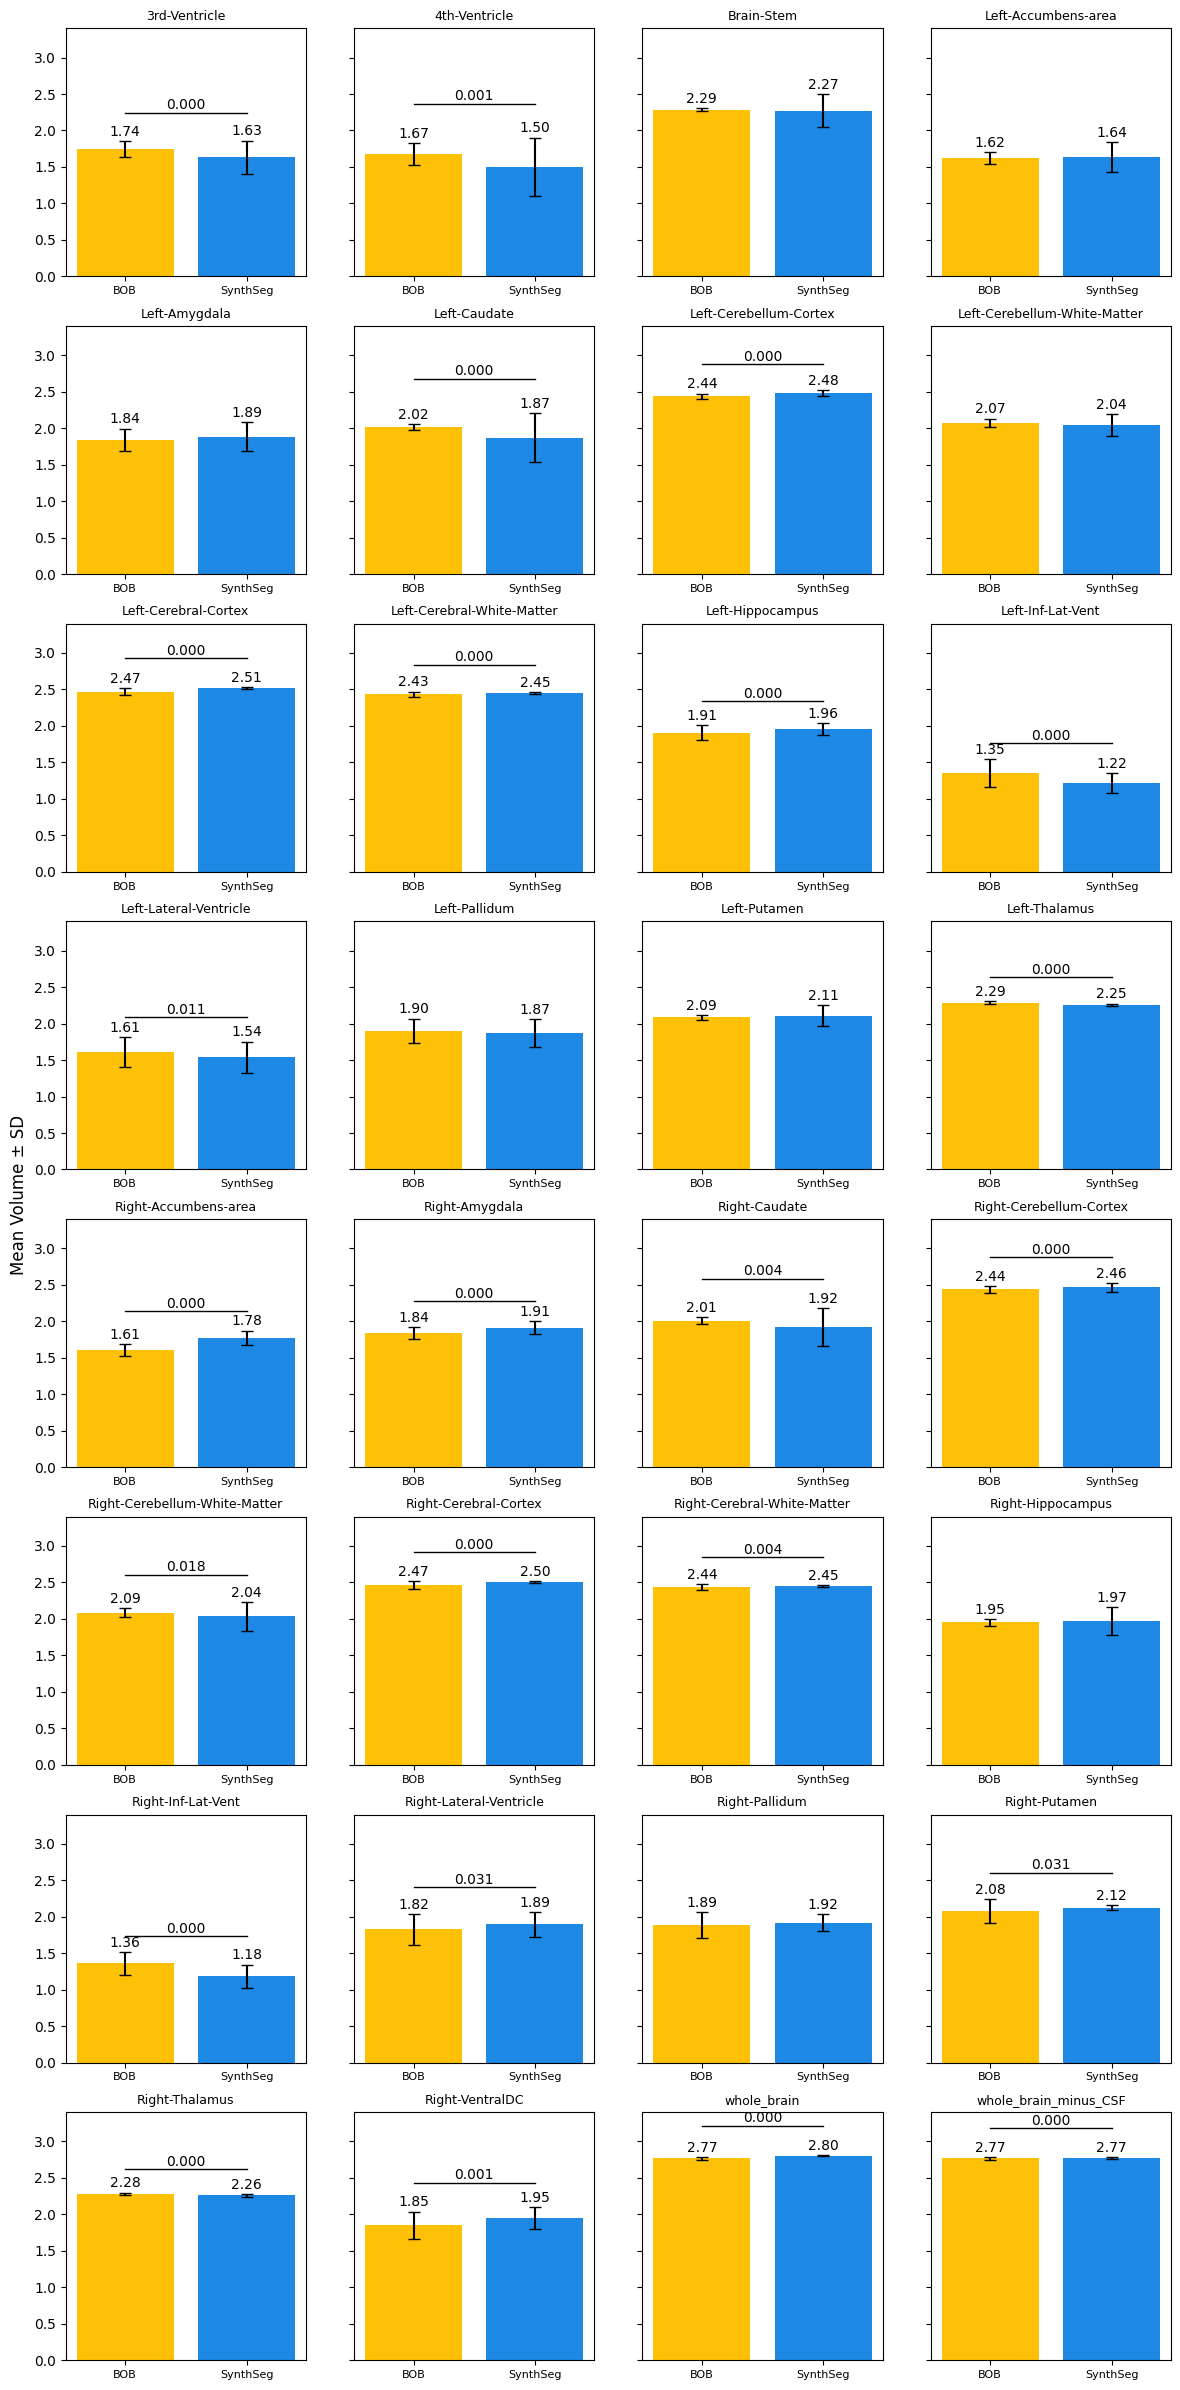

In [29]:
agg = df_fd_volume_metrics.groupby('name')[['fd_BOB', 'fd_SynthSeg']].agg(['mean', 'std'])

n_pairs = len(base_list)
ncols = 4
nrows = int(np.ceil(n_pairs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=True)
axes = axes.flatten()

for ax, label in zip(axes, base_list):
    if label not in agg.index:
        ax.axis('off')
        continue
    means = agg.loc[label][('fd_BOB', 'mean')], agg.loc[label][('fd_SynthSeg', 'mean')]
    stds  = agg.loc[label][('fd_BOB', 'std')],  agg.loc[label][('fd_SynthSeg', 'std')]

    x = np.arange(2)
    ax.bar(x, means, yerr=stds, capsize=4, color=colors_seg)
    ax.set_xticks(x)
    ax.set_xticklabels(['BOB', 'SynthSeg'], fontsize=8)
    ax.set_title(label, fontsize=9)

    # Annotate mean values
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)

        
    # Significance p-value
    p = float(df_stats[df_stats['name'] == label]['p-val'].iloc[0])
    if p < 0.05:
        y0 = (max(means) + max(stds))*1.14
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}", ha='center', va='bottom', fontsize=10)


# Turn off empty subplots
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Mean Volume ± SD")
plt.setp(axes, ylim=(0, 3.4))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

Showing the sign. differences after Bonferroni correction 

In [28]:
# number of paired tests
n_tests = len(df_stats)
alpha_corr = 0.05 / n_tests

df_stats['p_nominal'] = df_stats['p-val'].astype(float)
df_stats['sign_corr'] = df_stats['p_nominal'] < alpha_corr

print(f"Bonferroni α = {alpha_corr:.4f}")
df_stats.loc[df_stats['sign_corr'], ['name', 'FD (BOB)', 'FD (SynthSeg)', 'FD (diff)', 'p-val', 'd']]

Bonferroni α = 0.0016


name     FD (BOB) FD (SynthSeg)     FD (diff)  \
0                3rd-Ventricle  1.74 ± 0.11   1.63 ± 0.23   0.11 ± 0.17   
1                4th-Ventricle  1.67 ± 0.15   1.50 ± 0.40   0.17 ± 0.42   
5                 Left-Caudate  2.02 ± 0.04   1.87 ± 0.33   0.15 ± 0.31   
6       Left-Cerebellum-Cortex  2.44 ± 0.03   2.48 ± 0.04  -0.04 ± 0.03   
8         Left-Cerebral-Cortex  2.47 ± 0.05   2.51 ± 0.01  -0.05 ± 0.04   
9   Left-Cerebral-White-Matter  2.43 ± 0.04   2.45 ± 0.01  -0.02 ± 0.04   
10            Left-Hippocampus  1.91 ± 0.10   1.96 ± 0.08  -0.05 ± 0.10   
11           Left-Inf-Lat-Vent  1.35 ± 0.19   1.22 ± 0.14   0.14 ± 0.23   
15               Left-Thalamus  2.29 ± 0.02   2.25 ± 0.02   0.03 ± 0.02   
16        Right-Accumbens-area  1.61 ± 0.08   1.78 ± 0.10  -0.17 ± 0.13   
17              Right-Amygdala  1.84 ± 0.09   1.91 ± 0.09  -0.08 ± 0.07   
19     Right-Cerebellum-Cortex  2.44 ± 0.05   2.46 ± 0.06  -0.03 ± 0.04   
21       Right-Cerebral-Cortex  2.47 ± 0.05   2.50 ± 0.02  -0.04 ± 0.05   
24          Right-Inf-Lat-Vent  1.36 ± 0.16   1.18 ± 0.16   0.18 ± 0.16   
28              Right-Thalamus  2.28 ± 0.02   2.26 ± 0.02   0.02 ± 0.01   
29             Right-VentralDC  1.85 ± 0.19   1.95 ± 0.15  -0.10 ± 0.23   
30                 whole_brain  2.77 ± 0.02   2.80 ± 0.01  -0.04 ± 0.01   
31       whole_brain_minus_CSF  2.77 ± 0.02   2.77 ± 0.01  -0.01 ± 0.02   

    p-val      d  
0   0.000   0.64  
1   0.001   0.41  
5   0.000   0.48  
6   0.000  -1.32  
8   0.000  -1.09  
9   0.000  -0.54  
10  0.000  -0.47  
11  0.000   0.60  
15  0.000   2.01  
16  0.000  -1.25  
17  0.000  -1.10  
19  0.000  -0.73  
21  0.000  -0.78  
24  0.000   1.14  
28  0.000   1.25  
29  0.001  -0.42  
30  0.000  -3.34  
31  0.000  -0.50

### BOB/SynthSeg over age

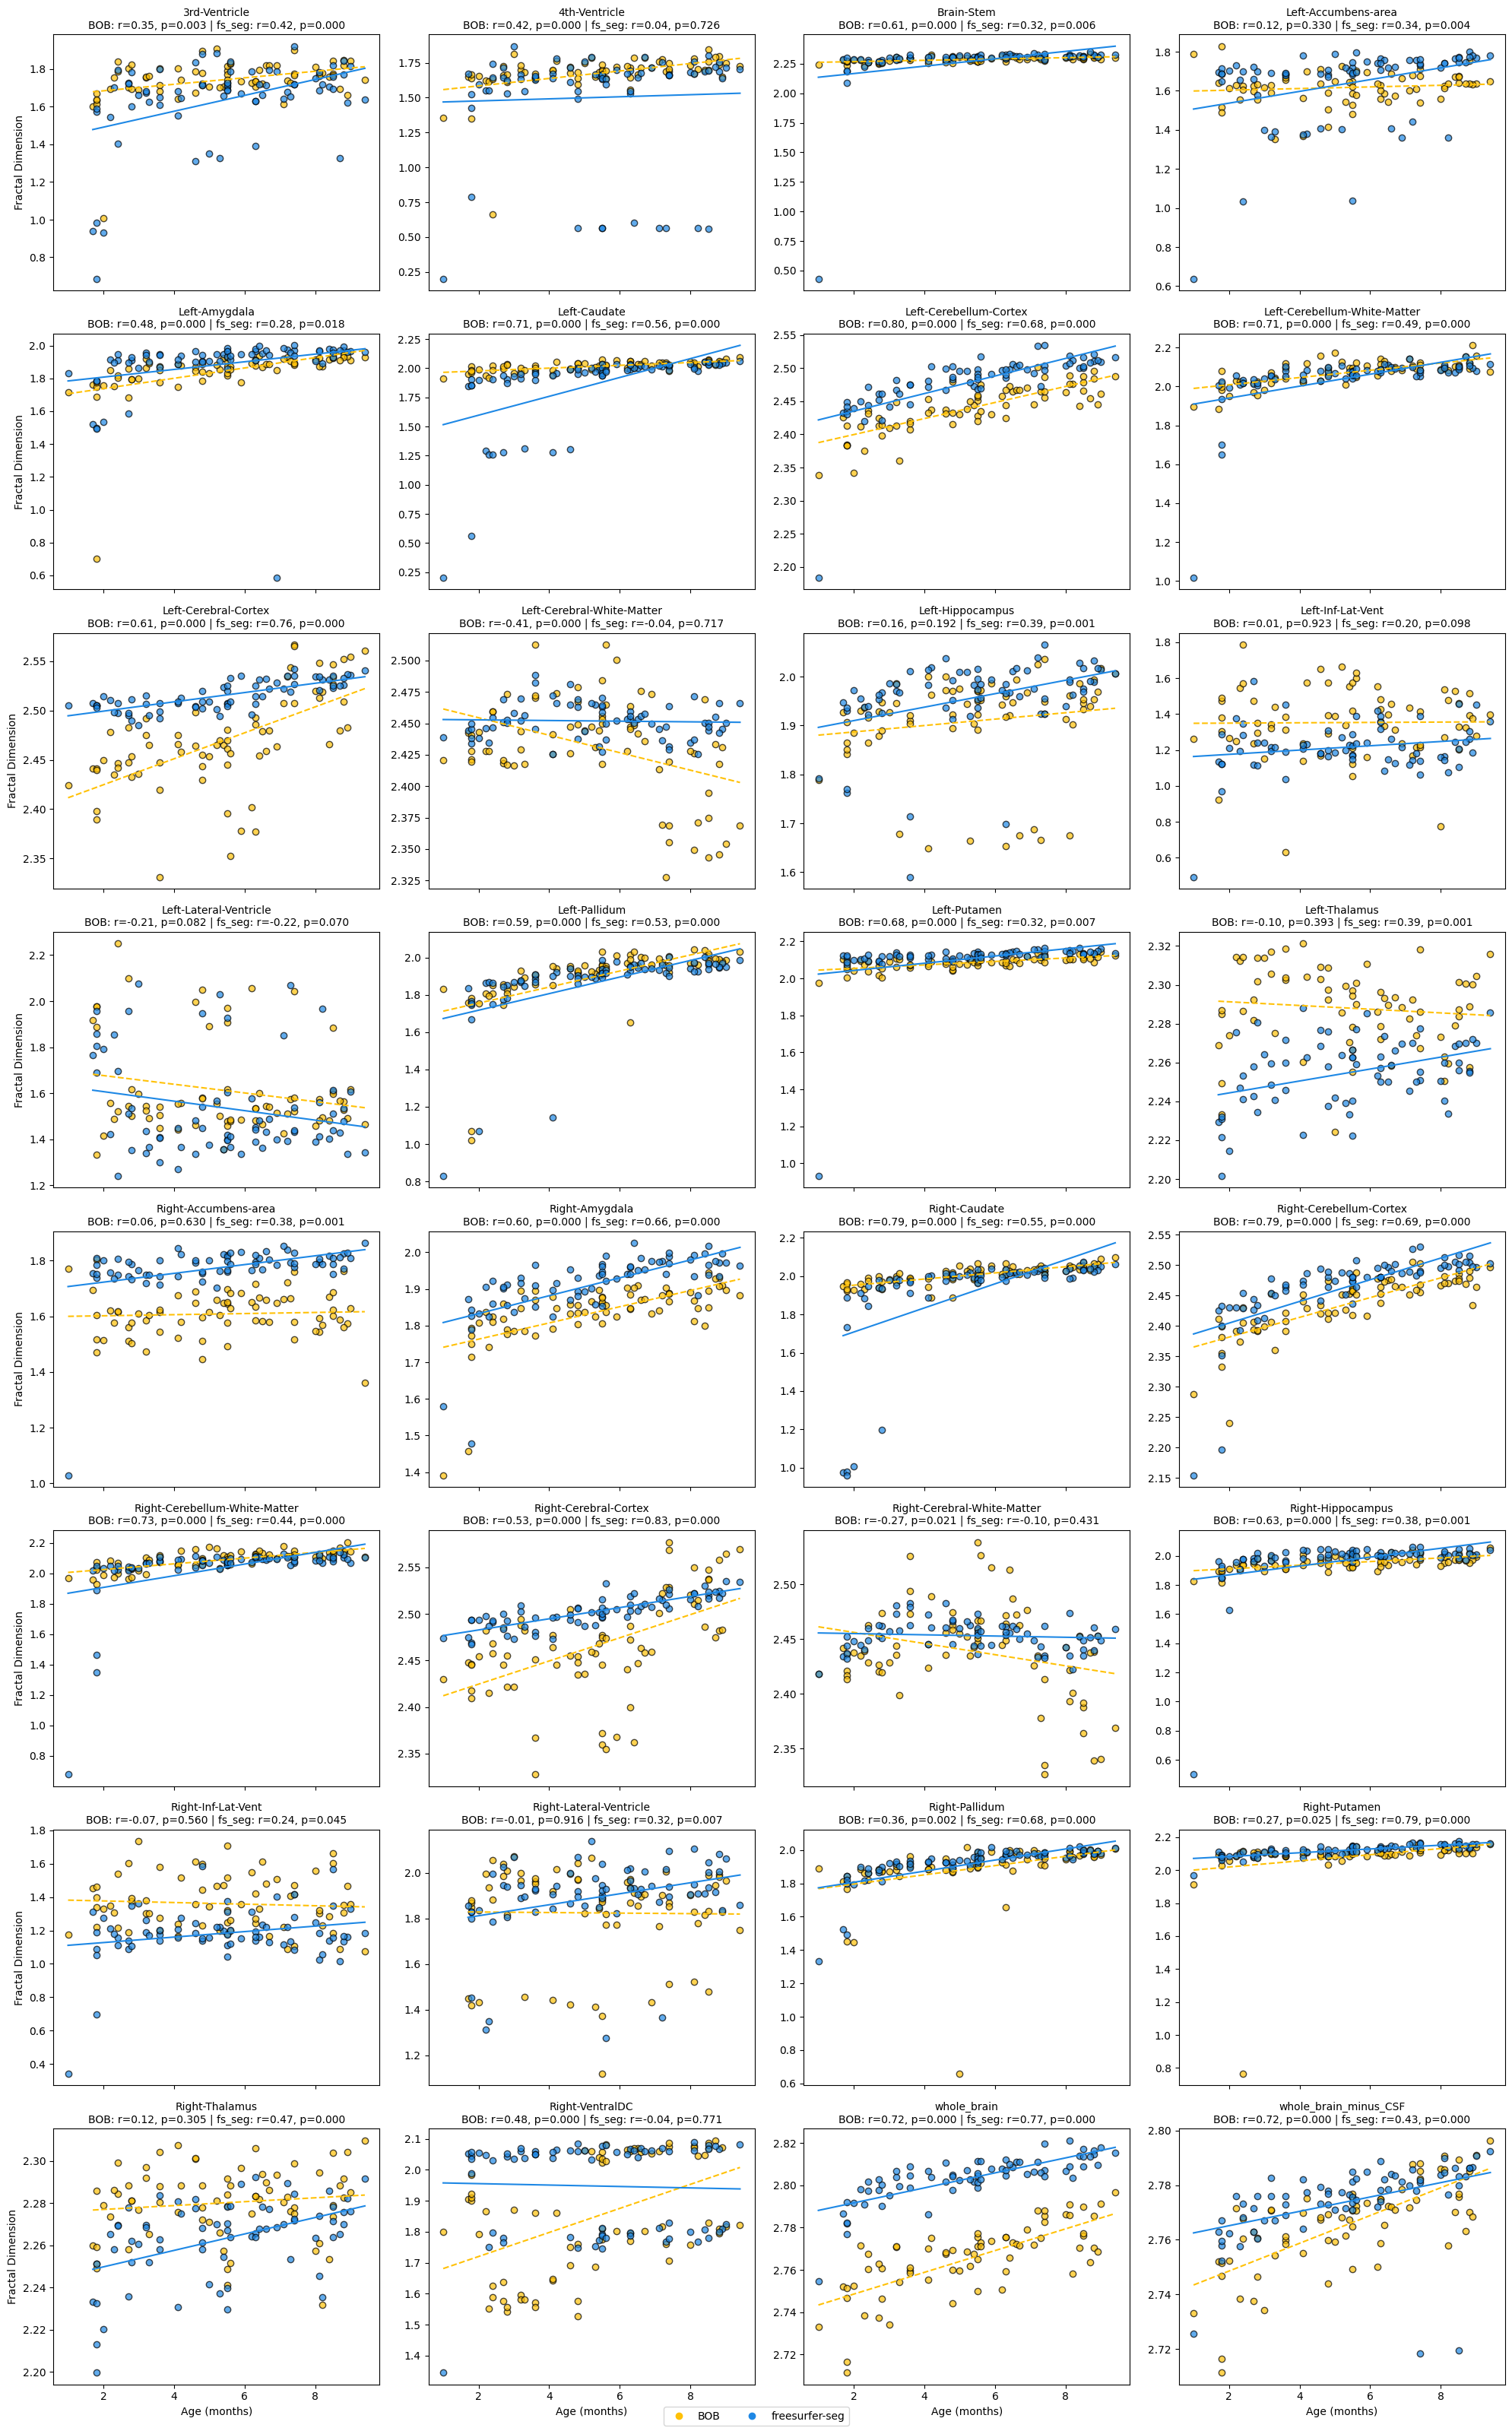

In [ ]:


n = len(base_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols * 5, nrows * 4),
                         sharex=True)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    
    sub = df_fd_volume_metrics[df_fd_volume_metrics['name'] == base]
    ages = sub['age'].values
    
    fds_BOB = sub['fd_BOB'].values
    fds_fs_seg = sub['fd_SynthSeg'].values
    
    # Scatter plot for each method
    ax.scatter(ages, fds_BOB, label='BOB', color=colors_seg[0], edgecolor='k', alpha=0.7)
    ax.scatter(ages, fds_fs_seg, label='SynthSeg', color=colors_seg[1], edgecolor='k', alpha=0.7)
    
    # Fit regression line for BOB
    if len(ages) > 1:
        slope_bob, intercept_bob = np.polyfit(ages, fds_BOB, 1)
        x_line = np.linspace(ages.min(), ages.max(), 100)
        y_line_bob = slope_bob * x_line + intercept_bob
        ax.plot(x_line, y_line_bob, color=colors_seg[0], linestyle='--')

    # Fit regression line for fs_seg
    if len(ages) > 1:
        slope_fs, intercept_fs = np.polyfit(ages, fds_fs_seg, 1)
        y_line_fs = slope_fs * x_line + intercept_fs
        ax.plot(x_line, y_line_fs, color=colors_seg[1], linestyle='-')
    
    # Pearson correlations
    r_bob, p_bob = pearsonr(ages, fds_BOB)
    r_fs, p_fs = pearsonr(ages, fds_fs_seg)

    ax.set_title(f"{base}\nBOB: r={r_bob:.2f}, p={p_bob:.3f} | fs_seg: r={r_fs:.2f}, p={p_fs:.3f}", fontsize=10)
    
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    if idx % ncols == 0:
        ax.set_ylabel("Fractal Dimension")

# Turn off unused axes
for j in range(n, len(axes)):
    axes[j].axis('off')

# Add legend once
handles = [plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[0], label='BOB'),
           plt.Line2D([], [], marker='o', linestyle='None', color=colors_seg[1], label='freesurfer-seg')]
fig.legend(handles=handles, loc='lower center', ncol=2)

plt.tight_layout()
plt.show()


### Correlation with quality metrics

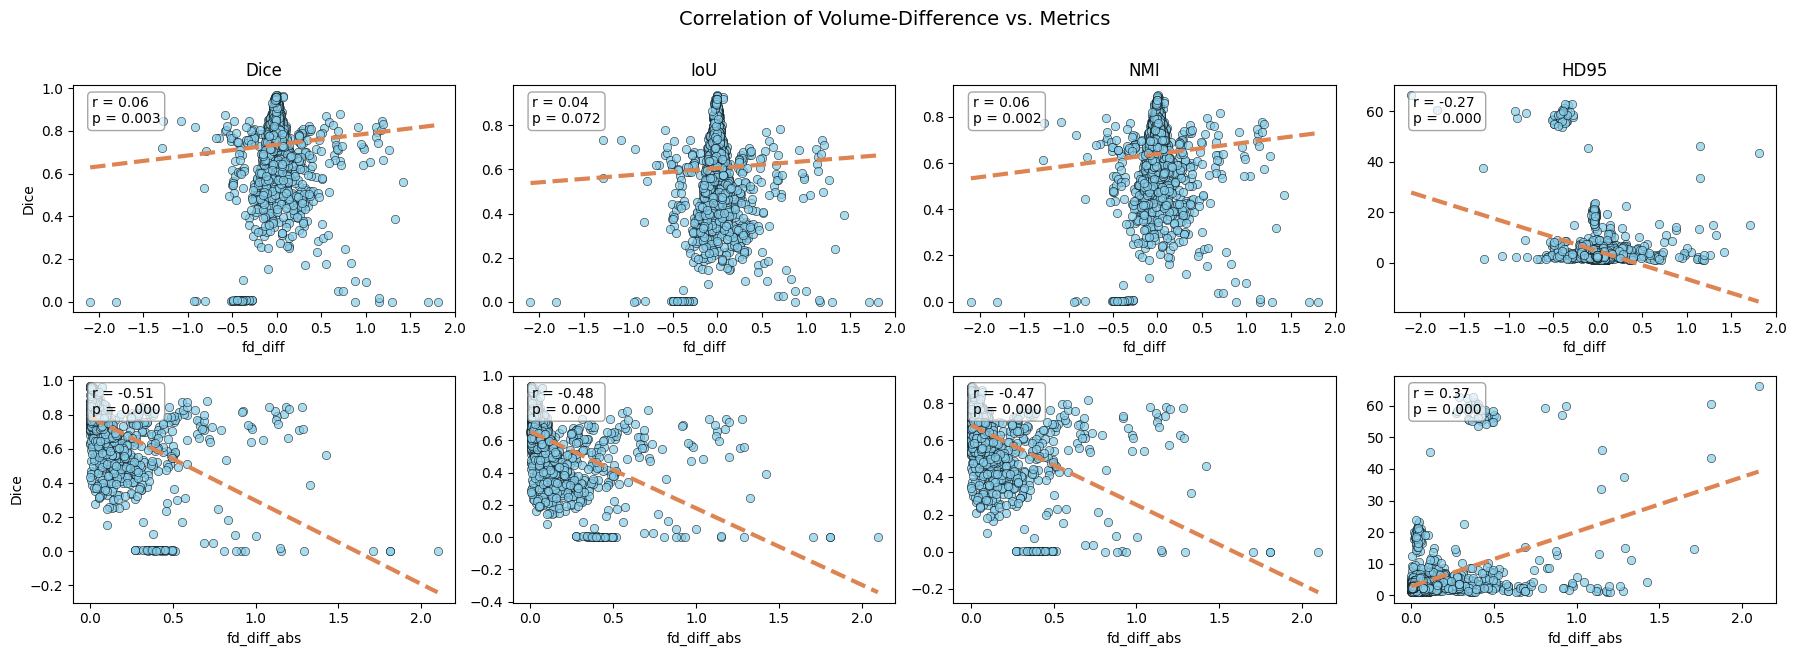

In [101]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_cols  = ["fd_diff", "fd_diff_abs"]

nrows = len(x_cols)   
ncols = len(metrics) 

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 4.5, nrows * 3.5),
    sharex=False
)

# Flatten axes for easy indexing if needed, but we'll also use a 2D index:
axes = np.array(axes)

for i, x_col in enumerate(x_cols):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        
        # Filter out NaNs
        sub = df_fd_volume_metrics.dropna(subset=[x_col, metric])
        x = sub[x_col].values
        y = sub[metric].values
        
        # Scatter plot
        sns.scatterplot(x=x, y=y, ax=ax, color='skyblue', edgecolor='k', alpha=0.7)

        
        # Fit regression line if ≥ 2 points
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color="#dd8452", linestyle="--",lw=3)
        
        # Pearson correlation
        if len(x) > 1:
            r, p = pearsonr(x, y)
        else:
            r, p = np.nan, np.nan
        
        # Annotate r and p in top-left
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\np = {p:.3f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor="gray",
                alpha=0.7
            )
        )
        
        # Only set titles on the top row
        if i == 0:
            ax.set_title(metric, fontsize=12)
        
        # Only label y‐axis on the first column
        if j == 0:
            ax.set_ylabel(metric, fontsize=10)
        else:
            ax.set_ylabel("")
        

        ax.set_xlabel(x_col, fontsize=10)

# Tight layout and super‐title
fig.suptitle("Correlation of Volume‐Difference vs. Metrics", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.975])
plt.show()


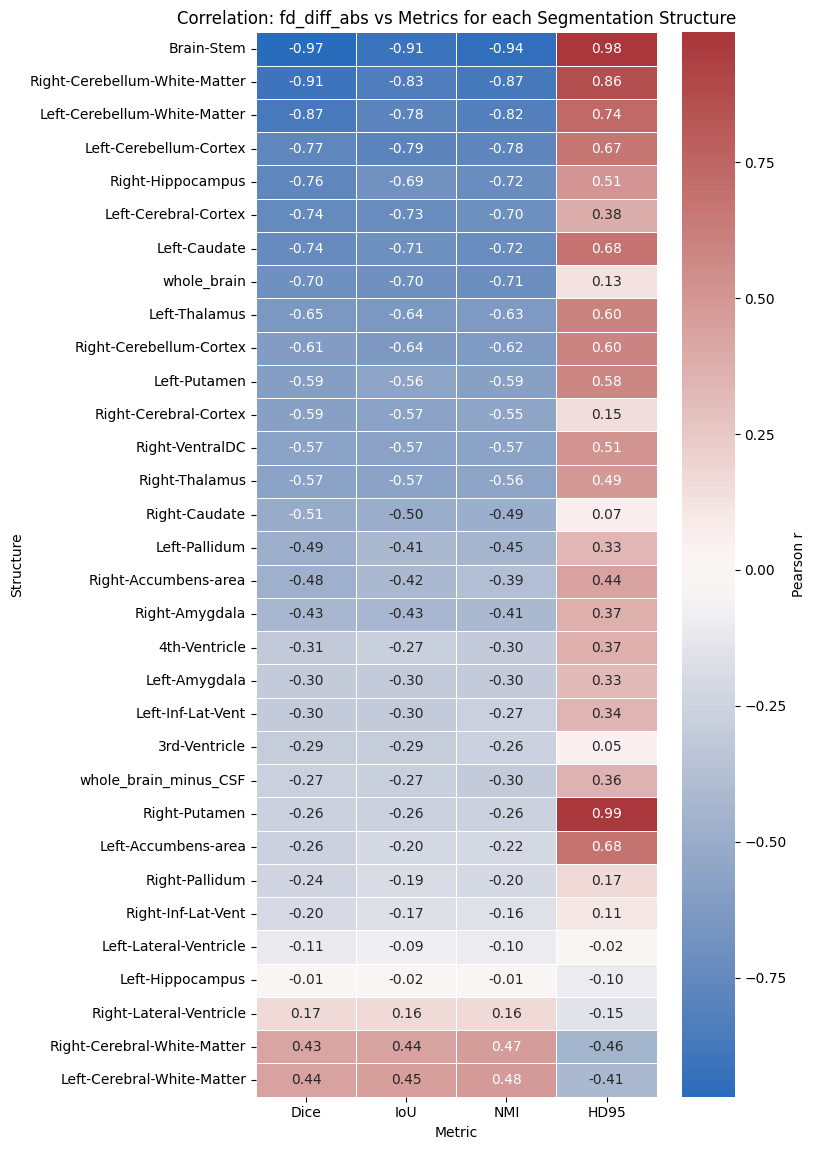

In [107]:
metrics = ["Dice", "IoU", "NMI", "HD95"]
x_col = "fd_diff_abs"

structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

corr_df = pd.DataFrame(index=structures, columns=metrics, dtype=float)

# fill in corr_df for each structure & each metric, compute Pearson r
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    for metric in metrics:
        # Drop NaNs
        valid = sub[[x_col, metric]].dropna()
        if len(valid) > 1:
            r, _ = pearsonr(valid[x_col], valid[metric])
        else:
            r = np.nan
        corr_df.at[struct, metric] = r

corr_df = corr_df.sort_values(by="Dice", ascending=True)

# plot a heatmap of the correlation coefficients
plt.figure(figsize=(8, len(structures) * 0.3 + 2))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="vlag",     # diverging palette centered at 0
    center=0,
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5
)
plt.title(f"Correlation: {x_col} vs Metrics for each Segmentation Structure")
plt.xlabel("Metric")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()

## Volume diff and FD diff correlation

C:\Users\natha\AppData\Local\Temp\ipykernel_29300\1120478000.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


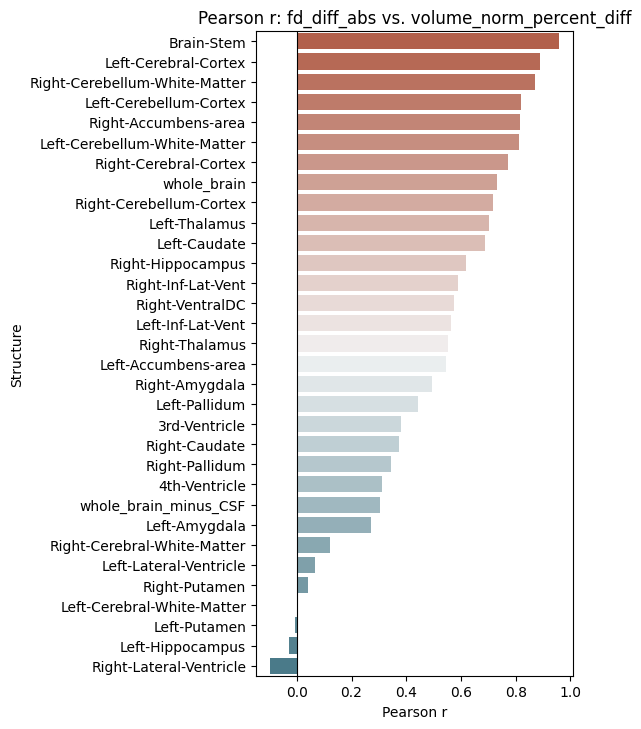

In [ ]:
structures = [name 
             for name in df_fd_volume_metrics['name'].unique() 
             if name != 'CSF']

# for each structure, compute Pearson r between fd_diff_abs and volume_norm_percent_diff
corr_list = []
for struct in structures:
    sub = df_fd_volume_metrics[df_fd_volume_metrics["name"] == struct]
    sub = sub.dropna(subset=["fd_diff_abs", "volume_norm_percent_diff"])
    if len(sub) > 1:
        r, p = pearsonr(sub["volume_norm_percent_diff"], sub["fd_diff_abs"])
    else:
        r, p = np.nan, np.nan
    corr_list.append({"name": struct, "r": r, "p": p})

corr_df = pd.DataFrame(corr_list).set_index("name").sort_values("r", ascending=False)
palette = sns.diverging_palette(20, 220, n=len(df_plot), as_cmap=False)

# barplot of correlation coefficients
plt.figure(figsize=(6, len(corr_df) * 0.2 + 1))
sns.barplot(
    x="r",
    y=corr_df.index,
    data=corr_df.reset_index(),
    palette=palette,
)
plt.axvline(0, color="k", linewidth=0.8)
plt.title("Pearson r: fd_diff_abs vs. volume_norm_percent_diff")
plt.xlabel("Pearson r")
plt.ylabel("Structure")
plt.tight_layout()
plt.show()